# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: 3
* Students: Baptiste Hériard-Dubreuil, Jean-Baptiste Membrado, Guilhem Noiraud, Amaury Véron 
* Dataset: Flight routes

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [1]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [2]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [3]:
adjacency =  np.load("adjacency.npy")
n_nodes =  len(adjacency[0])

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [4]:
sparse_adjacency = sparse.csr_matrix(adjacency)

laplacian_combinatorial =  sparse.csgraph.laplacian(sparse_adjacency)
laplacian_normalized =  sparse.csgraph.laplacian(sparse_adjacency, normed = True)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [5]:
laplacian =  laplacian_combinatorial

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [6]:
computation =  scipy.linalg.eig(laplacian.toarray(), left = True)
eigenvectors = computation[1]
eigenvalues =  computation[0]

#Sort to have ordered eigenvalues
idx = eigenvalues.argsort()  
eigenvalues = np.clip(np.real(eigenvalues[idx]), 1e-10, np.Inf) - 1e-10 #corrects the computation approximations
eigenvectors = np.real(eigenvectors[:,idx])

#print(eigenvalues)

assert eigenvectors.shape == (n_nodes, n_nodes)

In [7]:
eigenvalues[0:20]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03909034, 0.05542375, 0.0600207 , 0.06635115, 0.06818503,
       0.08202385, 0.08870359, 0.10449155, 0.10522678, 0.10791315])

In [8]:
eigenvectors #ne contient pas le vecteur propre composé de 1

array([[ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
         3.94657912e-04,  3.54266824e-04,  1.52028928e-04],
       [ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
         5.61259729e-05,  1.17247402e-04,  4.47309548e-05],
       [ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
         8.50677161e-05,  1.65326859e-04,  3.06267427e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
        -9.16524591e-07, -7.83593043e-07, -7.26477012e-07],
       [ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
         2.50151556e-08,  2.01921554e-08,  1.72658331e-08],
       [ 0.00000000e+00,  0.00000000e+00,  1.73972250e-02, ...,
        -1.43610574e-12,  1.71250840e-13,  1.20650062e-13]])

Justify your choice of eigensolver.

**We cannot use the sparse.linalg eigenvector solver, as it only computes a part of eigenvalues and eigenvectors. Instead, we use the scipy.linalg solver that does the whole computation.**

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**S is the incidence matrix of size $N \times M$.**

**$S^T$ is a matrix with $M$ lines and $N$ columns : on each line $j$ corresponding to the edge $j$, all the coefficients are null, except for the column corresponding to the output node where the value is $+1$, and for the input node, where the value is $-1$. If we consider $x \in \mathbb{R}^N$, then $S^T x$ is the vector with each coefficient being $x[i] - x[k]$, with $i$ being the output node for edge $j$, and $k$ being the input node.**

**If we see $x$ as a function from $V$ to $\mathbb{R}^N$, then each component $j$ of $S^T x$ is the derivative of the function along edge $j$. Globally, $S^T x$ is thus the gradient of the function.**

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**We can express the squared Euclidian norm as follow :**

**$\| S^\top u_k \|_2^2 = (S^\top u_k)^\top S^\top u_k = u_k^\top S S^\top u_k$**

**And $S S^\top = L$ so that : $\| S^\top u_k \|_2^2 = u_k^\top L u_k$**

**As $u_k$ is an eigenvector, we have : $L u_k = \lambda_k u_k$**

**And finally, $\| S^\top u_k \|_2^2 = \lambda_k \| u_k \|_2^2 = \lambda_k$**

**As the $u_k$ eigenvectors are of norm 1.**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**This squared norm is the squared norm of the gradient of $x$ if we consider $x$ as a function.**

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**The sum of all the coefficients of a line or column is equal to zero by nature of the matrix construction. So $u_0$, composed of ones, is the trivial eigenvector of each Laplacian and its eigenvalue is zero.**

In [9]:
#Verification
np.linalg.norm(np.dot(laplacian.toarray(),np.ones(3333).T))

0.0

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

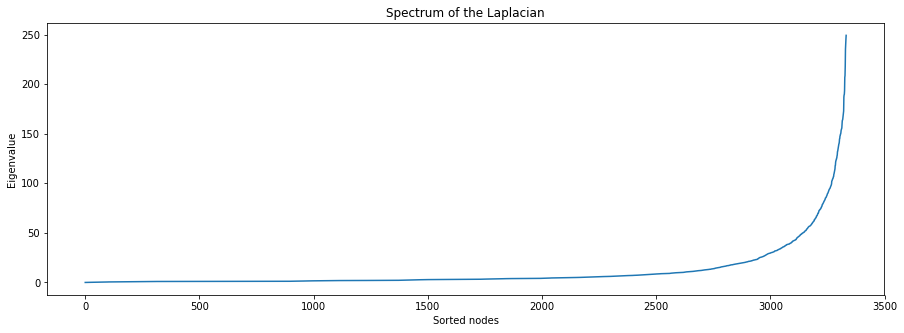

In [10]:
plt.figure(figsize=(15,5))
plt.plot(eigenvalues)
plt.title('Spectrum of the Laplacian')
plt.xlabel('Sorted nodes')
plt.ylabel('Eigenvalue')
plt.show()

**We have a lot of small eigenvalues, and only a few high ones. It seems to increase exponentially.**

How many connected components are there in your graph? Answer using the eigenvalues only.

In [11]:
#The number of connected components is equal to the multiplicity of the eigenvalue zero.
connected_components=len(eigenvalues)-np.count_nonzero(eigenvalues)
print('There are',connected_components,'connected components.')

There are 10 connected components.


Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

In [12]:
#Computation of the eigenvalues and eigenvectors for the normalized Laplacian
computation_norm =  scipy.linalg.eig(laplacian_normalized.toarray(), left = True)
eigenvectors_norm = computation_norm[1]
eigenvalues_norm =  computation_norm[0]

#Sort to have ordered eigenvalues
idx = eigenvalues_norm.argsort()  
eigenvalues_norm = np.real(eigenvalues_norm[idx])
eigenvectors_norm = np.real(eigenvectors_norm[:,idx])

In [13]:
#Largest eigenvalues
print('Largest possible eigenvalue for combinatorial Laplacian is equal to %.3f'%eigenvalues[len(eigenvalues)-1])
print('Largest possible eigenvalue for normalized Laplacian is equal to %.3f'%eigenvalues_norm[len(eigenvalues_norm)-1])

Largest possible eigenvalue for combinatorial Laplacian is equal to 249.217
Largest possible eigenvalue for normalized Laplacian is equal to 2.000


**For the combinatorial Laplacian, there is no upper bound for the eigenvalues. In our case, the highest lambda is equal to 249.217.**

**For the normalized Laplacian, eigenvalues are bounded by the upper bound 2, which is normal because we have a bipartite graph (departure nodes and arrival nodes).**

## 2 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

In [14]:
#Biggest cluster, it is allowed to use networkx for this
import networkx as nx

connected = sorted(nx.connected_component_subgraphs(nx.from_numpy_matrix(adjacency)), key = len, reverse=True)
biggest_cluster = connected[0]
biggest_cluster_matrix = nx.to_numpy_matrix(biggest_cluster)
sparse_cluster = sparse.csr_matrix(biggest_cluster_matrix)
len(biggest_cluster_matrix)

3304

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**The main idea behind eigenmaps is to drastically reduce the number of dimensions we are working on with the original graph while losing the least information.**

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [15]:
# Step 1: Construct a matrix of similarities 
# (ex: take the neighbours which distance d is smaller than epsilon, and put a weight of exp(-d^2/t), with t a parameter)

def construct_similarities_by_neighbourhood(adjacency, eps, t):
    n_nodes = adjacency.shape[0]
    W = np.zeros((n_nodes, n_nodes))
    distances = sparse.csgraph.shortest_path(adjacency, directed=False)

    for i in range(n_nodes):
        for j in range(n_nodes):
            if 0<distances[i,j] <= eps:
                W[i,j] = np.exp(-distances[i,j]**2/t)
                
    return sparse.csr_matrix(W)


W = construct_similarities_by_neighbourhood(sparse_cluster,1,1)

In [16]:
def eigenmaps_from_similarities(W, d, renormed=False):

    # Step 2: Compute the laplacian from this weight matrix
    lap, degrees = sparse.csgraph.laplacian(W, normed=True, return_diag=True)

    # Step 3: Compute the d eigenvectors associated to the d smallest eigenvalues.
    # For this, use a PARTIAL eigendecomposition
    _, v = sparse.linalg.eigs(lap, k=d+10, which='SM')
    v = v.argsort(0)[:,10:]
    
    
    # Step 4: Y is the concatenation of those eigenvectors multiplied by a parameter lambda so that Y'DY = eye.
    # We have 1/lambda_i = u_i'(D)u_i, and each column of Y is u_i
    # Then, the rows of Y are simply the coordonates for each node
    factors = v.T.dot(np.diag(degrees).dot(v))
    Y = np.real(v.dot(1/factors))

    # optionnal : renorm the eigenvectors by the degrees
    if renormed == True:
        for i in range(d):
            Y[:,i] = Y[:,i]/np.linalg.norm(Y[:,i])
    
    return Y, degrees

Y, D = eigenmaps_from_similarities(W, 2, renormed=True)

Plot the nodes embedded in 2D. Comment on what you see.

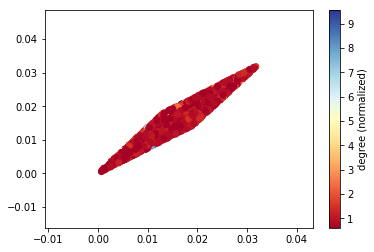

In [17]:
# Plot
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(Y[:,0], Y[:,1], c=D, cmap=cm, vmin=min(D), vmax=max(D))
cbar= plt.colorbar()
cbar.set_label("degree (normalized)")
plt.show()

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**The $Z$ embedding preserves the similarity between nodes. This function from the space of the nodes to a $d$-dimension space will map similar points close to each other.**

## 3 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**d=2 to have a 2D plot. k is random so far.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [18]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(Y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

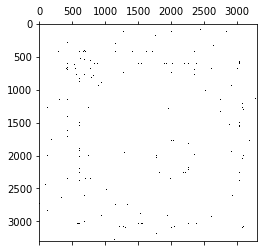

In [19]:
kmeans.labels_.tolist()

idx2 = kmeans.labels_.argsort()  
plt.spy(adjacency[idx2,:][:,idx2])
plt.show()

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [20]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

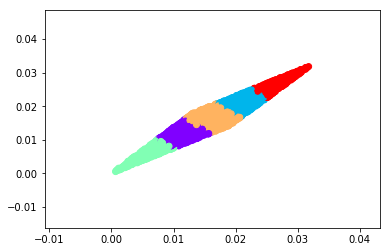

In [21]:
plt.scatter(Y[:,0],Y[:,1], c=kmeans.labels_, cmap='rainbow')  
plt.show()

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**